### visualize the pair_files (5 taxonomys)
- `seqs_taxo.pkl`

In [11]:
import pickle
from collections import defaultdict
import ast
import pandas as pd
import matplotlib as mpl
# import seaborn as sns
# mpl.get_backend()
import matplotlib.pyplot as plt
import numpy as np
from pyforest import *
from icecream import ic

In [12]:
"""seqs_tax.pkl (This file does not contain the common sequence data. Only the raw data.)
key: taxo_name
value: [SeqRecord(o.seq, o.id. o.name, o.description), ...] len(v) means how many orgranisms are in this taxonomy.

optional:
    If need the consensus strings, need to read con_file/{k}.txt
"""

seqs_taxo = defaultdict(list)
# [archaea, bacteria, eukary, virus, artificial]
# with open('pkl/seqs_taxo_5_total.pkl','rb') as f: # Five large species
# with open('pkl/seqs_taxo_fibrous.pkl','rb') as f: # fibrous
with open('pkl/seqs_taxo_resilin.pkl','rb') as f: # fibrous
    seqs_taxo = pickle.load(f)
# with open('pkl/seqs_species_8.pkl','rb') as f: # Eight small speceis
#     seqs_taxo = pickle.load(f)
# print(seqs_taxo)
# {k:name : v:full_sequence}
print(seqs_taxo.keys())

<IPython.core.display.Javascript object>

dict_keys(['Total'])


In [10]:
"""(Skip) pair counts in Consensus sequence.
"""
stat_all = defaultdict(list)
dict_all = dict()
for k, v in seqs_taxo.items(): # Missing some minor keys.
    # Read the pair_files/.txt, which is generated from gb_analysis.ipynb.
    with open(f'pair_files/{k}.txt') as f:
        list_pair = ast.literal_eval(f.read()) # list[tuple(2)]
        stat_all['tname'].append(k)
        stat_all['tlist'].append(list_pair)
        stat_all['tnum'].append(len(v))
        dict_all[k] = list_pair
len(dict_all)

200

In [11]:
len(stat_all['tname'])

200

In [14]:
stat_dat = pd.DataFrame(stat_all)

In [15]:
stat_dat.columns

Index(['tname', 'tlist', 'tnum'], dtype='object')

In [18]:
df = pd.DataFrame(stat_dat)

In [19]:
df

,tname,tlist,tnum
0,Bacteria,"[(nucleophilic - hydrophobic, 1617), (hydropho...",15579
1,Proteobacteria,"[(nucleophilic - hydrophobic, 651), (hydrophob...",3187
2,Betaproteobacteria,"[(nucleophilic - hydrophobic, 521), (nucleophi...",159
3,Burkholderiales,"[(nucleophilic - hydrophobic, 560), (nucleophi...",119
4,Firmicutes,"[(nucleophilic - hydrophobic, 118), (hydrophob...",8306
...,...,...,...
195,Peptostreptococcus,"[(hydrophobic - basic, 154), (nucleophilic - h...",318
196,Pseudomonadaceae,"[(nucleophilic - hydrophobic, 1151), (hydropho...",713
197,Pseudomonas,"[(nucleophilic - hydrophobic, 1151), (hydropho...",713
198,Rathayibacter,"[(nucleophilic - hydrophobic, 71), (nucleophil...",184


In [26]:
"""Generate all the 200 taxonomies paired AAs histograms from df."""
for i in range(200):
    pairs = df.iloc[i]['tlist']
    num = df.iloc[i]['tnum']
    name = df.iloc[i]['tname']
    labels, values = zip(*pairs)
    indexes = np.arange(len(labels))
    width = 1

    fig = plt.figure(figsize=(20,8))
    plt.barh(indexes, values, width)
    plt.yticks(indexes + width * 0.5, labels)
    plt.title(f'{name} pairwise frequency: adjacent residues ({num} adhesive proteins)')
    # plt.show()
    plt.savefig(f'hists-svg/{name}.svg')
    plt.close(fig)

In [ ]:
stat_df.head()

,tname,aa_sum,hydrophobic,nucleophilic,aromatic,acidic,amide,basic
0,Bacteria,"[(nucleophilic - hydrophobic, 1617), (hydropho...",41.496303,40.963462,0.0,17.540235,0.000000,0.000000
1,Proteobacteria,"[(nucleophilic - hydrophobic, 651), (hydrophob...",49.832589,25.892857,0.0,17.243304,7.031250,0.000000
2,Betaproteobacteria,"[(nucleophilic - hydrophobic, 521), (nucleophi...",30.258792,50.796284,0.0,12.873258,6.071666,0.000000
3,Burkholderiales,"[(nucleophilic - hydrophobic, 560), (nucleophi...",42.108626,45.559105,0.0,6.198083,6.134185,0.000000
4,Firmicutes,"[(nucleophilic - hydrophobic, 118), (hydrophob...",58.695652,12.826087,0.0,11.630435,9.021739,7.826087


In [ ]:
stat_df['aa_sum'][0]

[('nucleophilic - hydrophobic', 1617),
 ('hydrophobic - acidic', 879),
 ('nucleophilic - acidic', 734),
 ('nucleophilic - nucleophilic', 708),
 ('hydrophobic - hydrophobic', 660)]

In [ ]:
stat_df_simp = stat_df.drop(columns='aa_sum')
stat_df_simp.to_csv('pair_stats.csv', float_format='{:.2f}'.format)

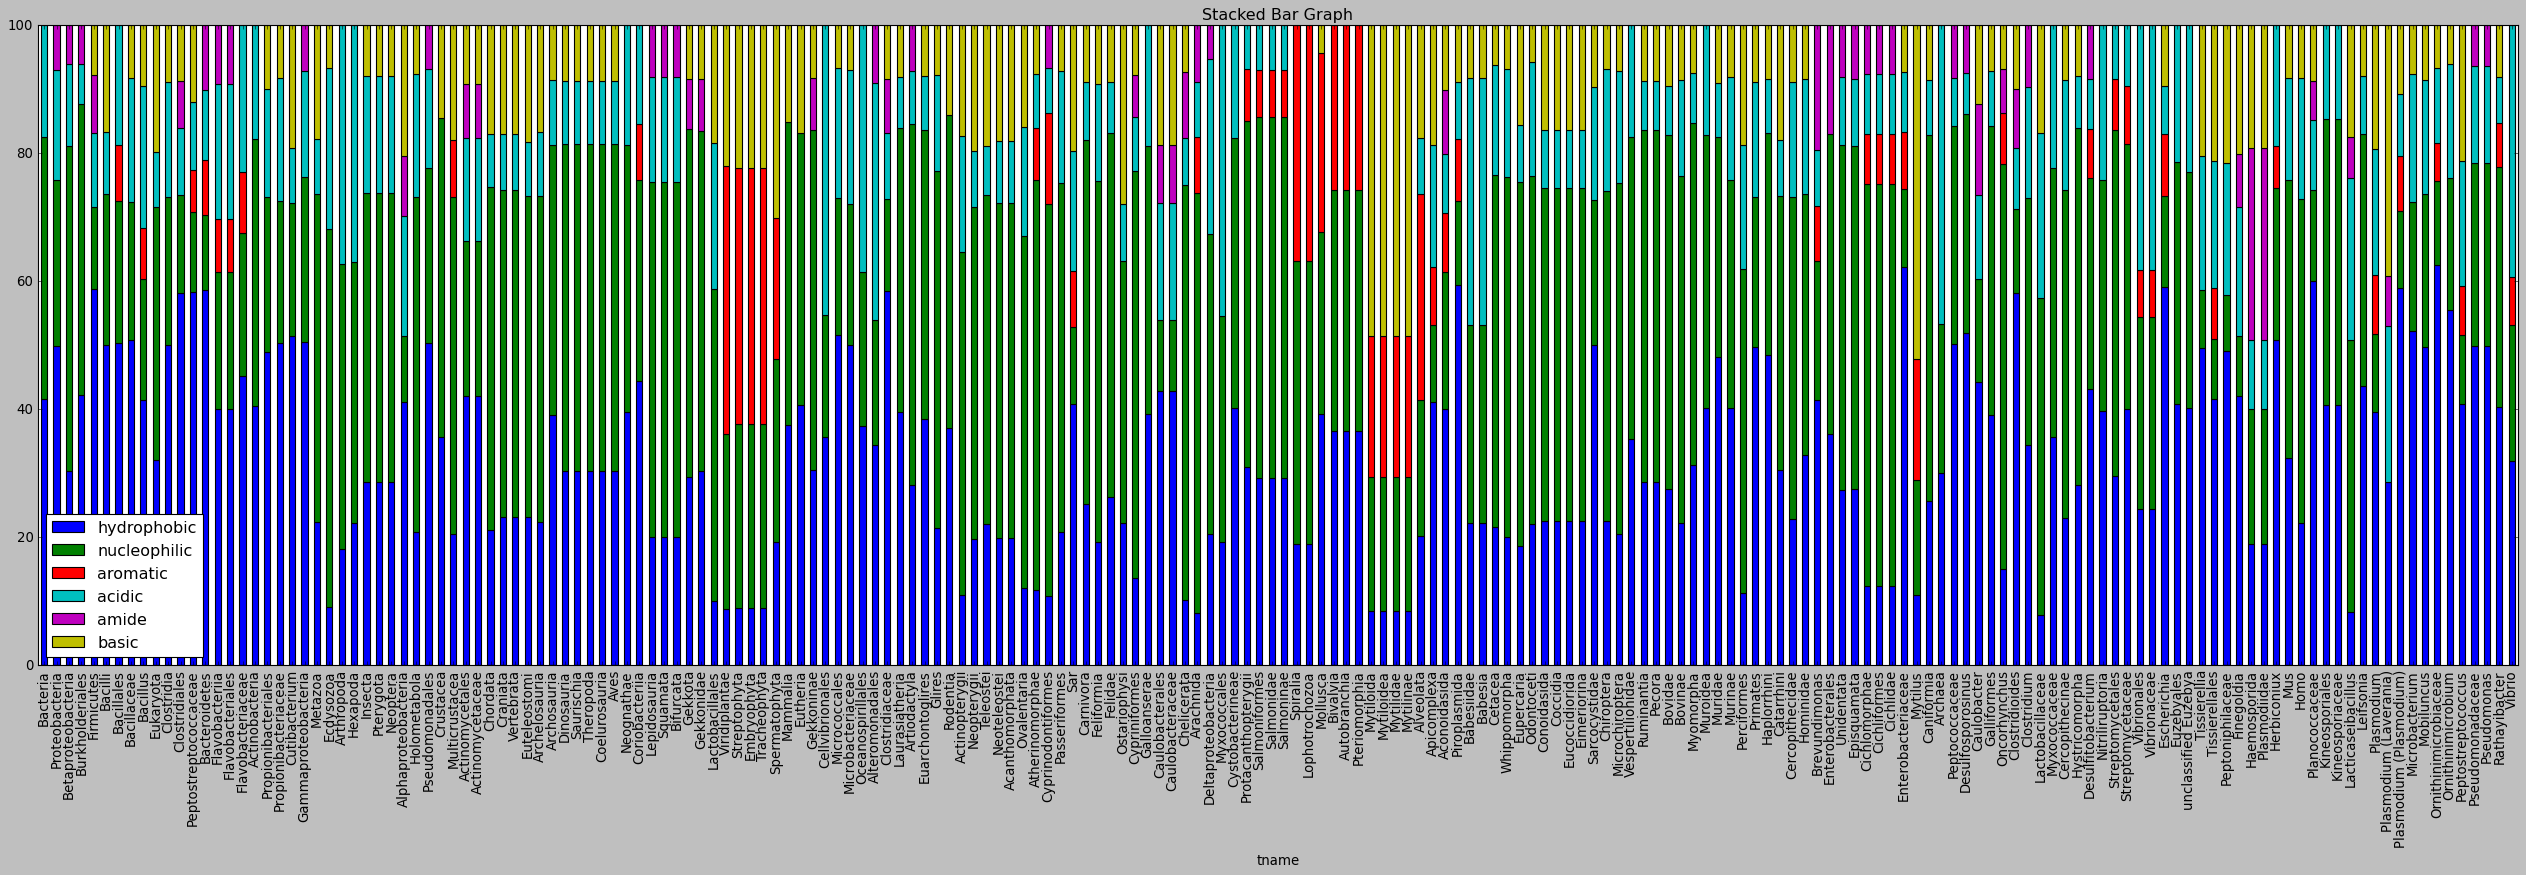

In [ ]:
stat_df_simp.plot(
    x = 'tname',
    kind = 'bar',
    stacked = True,
    title = 'Stacked Bar Graph',
    mark_right = True, figsize=(40,10))

plt.savefig('pdf/pair_stack_bar.pdf', bbox_inches='tight')

# For single As(subgroup) ratio analysis.

In [13]:

from Bio import AlignIO
from Bio import SeqIO
from Bio.Align import AlignInfo
from Bio.SeqRecord import SeqRecord
from tqdm import tqdm, trange
from icecream import ic
import collections

# from utils import *
import sequence_utils

from importlib import reload; reload(sequence_utils)
from sequence_utils import *

In [6]:
check_aa_ratios_overal(seqs_taxo['Total'], 'P')

(103536, 5083501, 0.020367065925628813)

### Figure 2B not classified

In [14]:
"""For Total sequence, but compute directly from the one sequence ratios."""
stat_dict = defaultdict(list)

# Iterate in the aln_files folder, producing con_files/*
for k, v in seqs_taxo.items():
    # align = AlignIO.read(f"aln_files/{k}.aln", "clustal") # clustalw_org1 alignment file computed by ClustalW
    # summary_align = AlignInfo.SummaryInfo(align)
    # consensus = summary_align.dumb_consensus()
    # header = f'MSA Consensus of {len(v)} seqs, protein'
    # Write common sequence to con_files, this is not filterred.
    stat_dict['tname'].append(k)
    # consensus = SeqIO.read(f'con_files/{k}.txt', 'fasta')
    # with open(f'con_files/{k}.txt', 'w') as f:
    #     print(SeqRecord(consensus, header, '', '').format('fasta'), file=f)
    # producing pair_files/*
    aa_dict, sum_counts = process_seq_list_not_classified(v)
    
    for k in aa_dict:
        stat_dict[k].append(aa_dict[k]*100/sum_counts)

        # stat_dict['hydrophobic'].append(aa_dict['hydrophobic']*100/sum_counts)
        # stat_dict['nucleophilic'].append(aa_dict['nucleophilic']*100/sum_counts)
        # stat_dict['aromatic'].append(aa_dict['aromatic']*100/sum_counts)
        # stat_dict['acidic'].append(aa_dict['acidic']*100/sum_counts)
        # stat_dict['amide'].append(aa_dict['amide']*100/sum_counts)
        # stat_dict['basic'].append(aa_dict['basic']*100/sum_counts)

stat_df = pd.DataFrame(stat_dict)


In [15]:
stat_df.head(20)
# new_df = stat_df.drop(columns='aa_sum')
# from summarytools import summarytools
# summarytools.dfSummary(new_df)

# from skimpy import skim
# skim(new_df)

# from ydata_profiling import ProfileReport
# report = ProfileReport(new_df)
# report.to_notebook_iframe()
# report.to_widgets()
# report.to_file('my_report.html')

# import sweetviz as sv
# report = sv.analyze(new_df)
# report.show_notebook()

# from dataprep.eda import create_report
# create_report(new_df)

,tname,S,T,C,V,L,I,M,P,G,...,D,E,N,Q,H,K,R,B,J,Z
0,Total,12.674475,3.661915,0.519941,4.63357,3.738459,1.583385,0.90389,9.106506,17.130316,...,4.479867,3.834254,5.427342,5.265014,1.918667,2.194346,4.248697,0.0,0.0,0.0


In [104]:
# stat_df_simp = stat_df.drop(columns='aa_sum')
# stat_df_simp.to_csv('single_stats.csv', float_format='{:.2f}'.format)

In [8]:
plt.style.use('seaborn-bright')
# import scienceplots
# plt.style.use('science')
# plt.style.use('ipynb')

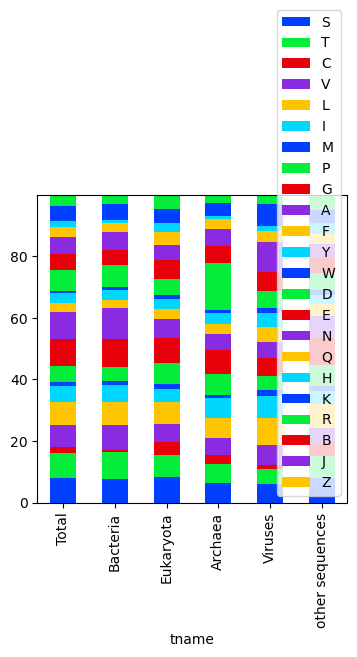

In [9]:
stat_df.plot(
    x = 'tname',
    kind = 'bar',
    stacked = True,
    # title = 'Stacked Bar Graph',
    mark_right = True, figsize=(4,4))
# plt.savefig('csv/subgroup_ratio_raw_small_8_p.pdf', bbox_inches='tight')
# plt.savefig('csv/subgroup_ratio_raw_p.pdf', bbox_inches='tight')
plt.savefig('figure2B_new/subgroup_ratio_raw_2B.pdf', bbox_inches='tight')

In [16]:
# stat_df.to_csv('csv/subgroup_ratio_raw_small_8_p.csv')
# stat_df.to_csv('csv/subgroup_ratio_raw_p.csv')
stat_df.to_csv('figure2B_fibrous_resilin/resilin_ratio_raw_2B.csv')

### Figure 2D: Pair stacked bar graph computation (pair counts) for Total.

In [22]:
"""seqs_tax.pkl (This file does not contain the common sequence data. Only the raw data.)
key: taxo_name
value: [SeqRecord(o.seq, o.id. o.name, o.description), ...] len(v) means how many orgranisms are in this taxonomy.

optional:
    If need the consensus strings, need to read con_file/{k}.txt
"""

seqs_taxo = defaultdict(list)
# with open('pkl/seqs_taxo_resilin.pkl','rb') as f:
with open('pkl/seqs_taxo_fibrous.pkl','rb') as f:
    seqs_taxo = pickle.load(f)
# print(seqs_taxo)
# {k:name : v:full_sequence}
print(seqs_taxo.keys())

<IPython.core.display.Javascript object>

dict_keys(['Total'])


In [23]:

stat_dict = defaultdict(list)
first = defaultdict(int)
second = defaultdict(int)
third = defaultdict(int)
fourth = defaultdict(int)
fifth = defaultdict(int)
rank_dict = {'1st': first, '2nd': second, '3rd': third, '4th': fourth, '5th': fifth}
subgroup_dict = {}

# Iterate in the aln_files folder, producing con_files/*
for k,v in seqs_taxo.items():
    # align = AlignIO.read(f"aln_files/{k}.aln", "clustal") # clustalw_org1 alignment file computed by ClustalW
    # summary_align = AlignInfo.SummaryInfo(align)
    # consensus = summary_align.dumb_consensus()
    # header = f'MSA Consensus of {len(v)} seqs, protein'
    # Write common sequence to con_files, this is not filterred.
    # stat_dict['tname'].append(k)
    # consensus = SeqIO.read(f'con_files/{k}.txt', 'fasta')
    # with open(f'con_files/{k}.txt', 'w') as f:
    #     print(SeqRecord(consensus, header, '', '').format('fasta'), file=f)
    # producing pair_files/*
    
    subgroup = process_pair_list(v)
    subgroup_dict[k] = subgroup
    
    # c.most_common()
    # with open(f'single_files/{k}.txt', 'w') as f:
    #     print(c.most_common(), file=f)
    """Top 5 pairs cut.
    """




In [24]:
subgroup_df = pd.DataFrame(subgroup_dict)
subgroup_df

,Total
acidic - acidic,7690
acidic - amide,7813
acidic - basic,14927
amide - amide,6174
amide - basic,16876
aromatic - acidic,6972
aromatic - amide,7267
aromatic - aromatic,2763
aromatic - basic,15989
basic - basic,13228


In [25]:
sorted_df = subgroup_df.sort_values(by=['Total'], ascending=False)
for col in sorted_df.columns:
    sorted_df[col] = sorted_df[col] / sum(sorted_df[col])
sorted_df

,Total
hydrophobic - basic,0.115246
nucleophilic - hydrophobic,0.112646
hydrophobic - hydrophobic,0.095105
hydrophobic - acidic,0.078286
hydrophobic - amide,0.077479
nucleophilic - basic,0.048928
amide - basic,0.046196
hydrophobic - aromatic,0.045290
aromatic - basic,0.043768
nucleophilic - amide,0.043601


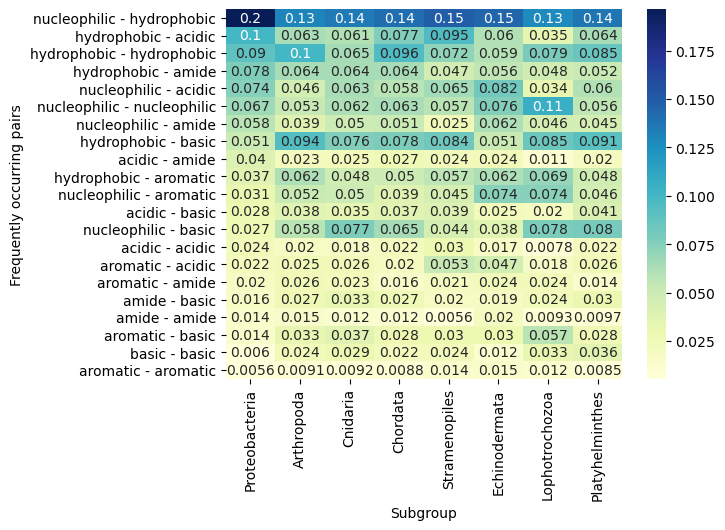

In [10]:
ax = sns.heatmap(sorted_df, annot=True, cmap="YlGnBu")
ax.set_xlabel("Subgroup")
ax.set_ylabel("Frequently occurring pairs")
plt.savefig("csv/total_paircounts_heatmap_p.pdf", bbox_inches="tight")

In [26]:
# sorted_df.to_csv('figure2B_fibrous_resilin/resilin_pair_ratio_2D.csv')
sorted_df.to_csv('figure2B_fibrous_resilin/fibrous_pair_ratio_2D.csv')


### Figure 2C: Contiguted As block distribution counts. (block_size)

In [12]:

import sequence_utils

from importlib import reload; reload(sequence_utils)
from sequence_utils import *


  0%|          | 0/24707 [00:00<?, ?it/s]

100%|██████████| 24707/24707 [00:12<00:00, 1929.54it/s]


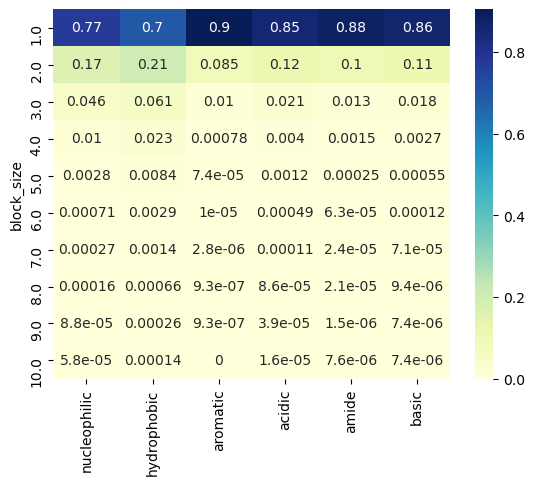

In [13]:

from itertools import groupby
import seaborn as sns
stat_dict = defaultdict(list)
block_max = 10
mat = np.zeros((block_max, 7))

# Iterate in the aln_files folder, producing con_files/*
for v in tqdm(seqs_taxo['Total']):
    # align = AlignIO.read(f"aln_files/{k}.aln", "clustal") # clustalw_org1 alignment file computed by ClustalW
    # summary_align = AlignInfo.SummaryInfo(align)
    # consensus = summary_align.dumb_consensus()
    # header = f'MSA Consensus of {len(v)} seqs, protein'
    # Write common sequence to con_files, this is not filterred.
    # stat_dict['tname'].append(k)
    # consensus = SeqIO.read(f'con_files/{k}.txt', 'fasta')
    # with open(f'con_files/{k}.txt', 'w') as f:
    #     print(SeqRecord(consensus, header, '', '').format('fasta'), file=f)
    # producing pair_files/*
    one_mat = fill_heatmap_mat(v.seq)
    mat += one_mat


    # Note that df.plot(kind=) in default use the first column as the index, i.e. the x axis.
    # This time not use defaultdict(list), but use np.zeros to generte the ndarrays to store data and fill it out.

mat[:,0] = np.array(list(range(1, block_max+1)))
mat_percent = np.zeros((block_max, 7))

for i in range(10):
    for j in range(1,7):
        mat_percent[i][j] = mat[i][j]/np.sum(mat[:,j])

mat_percent[:,0] = np.array(list(range(1, block_max+1)))

df = pd.DataFrame(mat_percent, columns=['block_size', 'nucleophilic', 'hydrophobic','aromatic', 'acidic', 'amide', 'basic'])
# """
        #    '2': 'nucleophilic',
        #    '3': 'hydrophobic',
        #    '4': 'aromatic',
        #    '5': 'acidic',
        #    '6': 'amide',
        #    '7': 'basic'}
        #    """
# stat_all = defaultdict(list)
# stat_all['block_size'] = list(range(1, block_max+1))
# ic(mc)
# ic(groups)
df_index = df.set_index('block_size')

sns.heatmap(df_index, annot=True, cmap="YlGnBu")
plt.savefig(f'csv/block_size_heatmap_p.pdf', bbox_inches='tight')
# plt.savefig(f'SI_figs/heatmap/{k}_heatmap.pdf', bbox_inches='tight')
# plt.clf()


In [14]:
df_index.to_csv('csv/block_size_heatmap_p.csv')